# Analysis of Timeline emails (2015-06)

This article was written using [Ipython Notebook](http://ipython.org/).

First we import all modules that we will use:

In [1]:
%matplotlib inline
import mailbox
import email.utils
import matplotlib.pyplot as plt
import subprocess
import sys
import re

Paths that you might need to change if you want to reproduce this document yourself:

In [2]:
PATH_TO_MALING_LIST_EXPORT = "thetimelineproj-user"
PATH_TO_REPO = "main-sf"

For reference, this is the Python version:

In [3]:
sys.version

'2.7.6 (default, Mar 22 2014, 22:59:56) \n[GCC 4.8.2]'

## An iterator for emails

I downloaded all emails from SourceForge. (You need to be project admin to do that.) It came in mbox format. We can work with it in Python like this:

In [4]:
def email_iterator():
    for message in mailbox.mbox(PATH_TO_MALING_LIST_EXPORT):
        yield Message(message)

class Message(object):
    
    def __init__(self, message):
        date = email.utils.parsedate_tz(message["date"])
        self.month_tuple = (date[0], date[1])
        self.subject = message.get("subject", "")

Let's see if we can get the title of the first email:

In [5]:
email_iterator().next().subject

'[Thetimelineproj-user] Test'

And count them all:

In [6]:
len(list(email_iterator()))

2126

## Email frequency

The first question I would like to answer is how email frequency looks like over time. Let's extract some data:

In [7]:
emails_per_month = {}
for message in email_iterator():
    emails_per_month[message.month_tuple] = emails_per_month.get(message.month_tuple, 0) + 1

Let's see if we got that right. What are the first 5 keys?

In [8]:
sorted(emails_per_month.keys())[:5]

[(2009, 6), (2009, 7), (2009, 8), (2009, 9), (2009, 10)]

Looks right. What about frequencies?

In [9]:
emails_per_month[(2009, 6)]

2

In [10]:
emails_per_month[(2009, 7)]

12

Looks good too. And how many emails have we got in total?

In [11]:
sum(emails_per_month.values())

2126

Next we would like to plot this data. Here are some functions for that:

In [12]:
def plot_frequencies_per_month(frequencies_per_month):
    (x, xlabels, y) = ([], [], [])
    
    index = 0
    for year in range(2009, 2016):
        for month in range(1, 13):
            x.append(index)
            xlabels.append("%d-%02d" % (year, month))
            y.append(frequencies_per_month.get((year, month), 0))
            index += 1

    plt.figure(figsize=(15, 5))
    plt.bar(x, y, align="center", color=(0.8, 0.8, 1))
    plt.xticks(x, xlabels, rotation=90)

    plot_moving_average(x, y, 6, "r")
    plot_moving_average(x, y, 12, "g")
    plot_moving_average(x, y, 24, (0, 0, 0))

    plt.legend()
    plt.tight_layout()
    plt.axis("tight")
    plt.grid(axis="y")
    
def plot_moving_average(x, y, period_length, color):
    averages = []
    for _ in range(period_length-1):
        averages.append(0)
    for index in range(len(y)-period_length+1):
        averages.append(sum(y[index:index+period_length]) / period_length)
    plt.plot(x, averages, color=color, linewidth=2, label="%d months moving average" % period_length)

And the result is this:

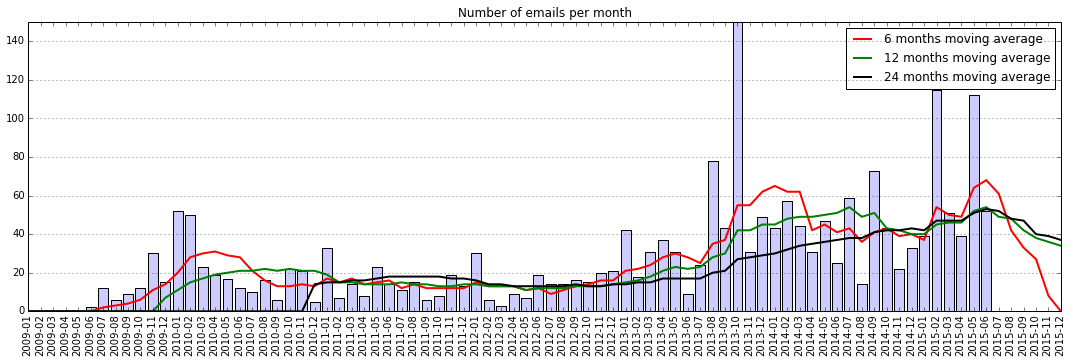

In [13]:
plot_frequencies_per_month(emails_per_month)
plt.title("Number of emails per month")
plt.show()

The email frequency seems pretty constant until around 2013-08. What happened then? On 30 September 2013 version 1.0.0 was released. The peak at 2013-10 is right after the 1.0.0 release. Does it mean that users are afraid to use software where the version number is < 1.0 because it feels unstable?

On the other hand, what does email frequncy mean? Let's have a look at the emails from 2013-10.

In [14]:
peak_emails = []
for message in email_iterator():
    if message.month_tuple == (2013, 10):
        peak_emails.append(message)

From the diagram, the number of peak emails should be a little over 140. Does it match?

In [15]:
len(peak_emails)

150

Let's look at the titles:

In [16]:
for subject in sorted(set(message.subject for message in peak_emails)):
    print(subject)

1 of 3 Event Hides or Disappears Upon Zoom-In
=?UTF-8?Q?SV:_Crash_report:_OverflowError:_l?=
	=?UTF-8?Q?ong_int_too_large_to_convert_to_int=E2=80=8F?=
=?windows-1256?Q?Crash_repo?= =?windows-1256?Q?rt:_Overfl?=
	=?windows-1256?Q?owError:_l?= =?windows-1256?Q?ong_int_to?=
	=?windows-1256?Q?o_large_to?= =?windows-1256?Q?_convert_t?=
	=?windows-1256?Q?o_int=FE?=
Ampersand breaks svg export
Bug report + suggestion .................and a supplicate
Can containers be nested?
Category Uncheck "stickyness"
Coding standards
Crash report: AttributeError: 'NoneType' object has no attribute
	'path'
Crash report: AttributeError: 'tuple' object has no attribute 'year'
Crash report: OverflowError: long int too large to convert to int
Feedback
Feedback + an addition
Feedback on event editor dialog
File Notification from brian@genalchemy.com: TLP-1.0-Problem.zip
Installing from source in Android?
Keyboard Shortcuts
Loss of Period Events Created in 2.1 Series Timeline
New category tree 
Numeric timeline

Not sure if this says anything.

## Crash report frequency

Now let's do the same frequency analysis but only include crash report emails. They were introduced later in Timeline and therefore we should not see such reports early on.

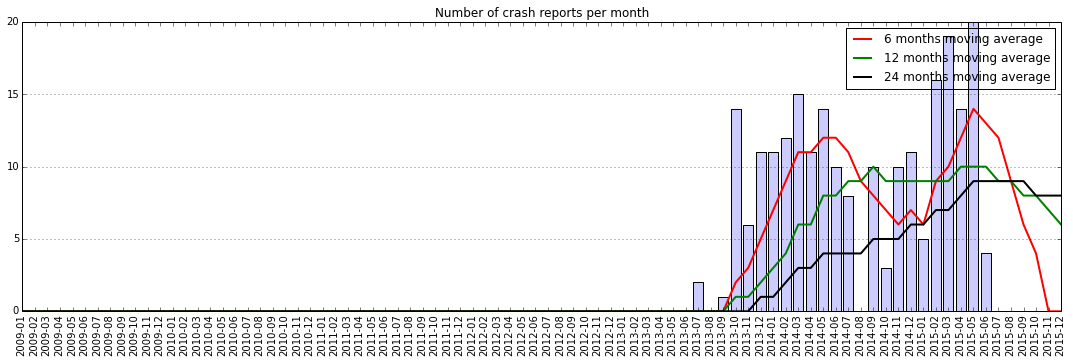

In [17]:
crash_reports_per_month = {}
for message in email_iterator():
    if "Crash report" in message.subject:
        crash_reports_per_month[message.month_tuple] = crash_reports_per_month.get(message.month_tuple, 0) + 1
        
plot_frequencies_per_month(crash_reports_per_month)
plt.title("Number of crash reports per month")
plt.show()

It's a little harder to see a trend here becuase of lack of data early on. But it looks like there is a slight increase around 2015-02. What happened then? Nothing in particular from the changelog.

## Commit frequency

It would be interesting to look at the repo history. What are the number of commits each month? Does that affect the number of emails or crash reports each month?

We can extract the frequencies of commits per month like this:

In [18]:
output = subprocess.check_output([
    "hg", "log",
    "--template", "{date|isodate}\n"
], cwd=PATH_TO_REPO)

commits_per_month = {}

for line in output.strip().split("\n"):
    match = re.match(r"(\d{4})-(\d{2})", line)
    month_tuple = (int(match.group(1)), int(match.group(2)))
    commits_per_month[month_tuple] = commits_per_month.get(month_tuple, 0) + 1

The plot:

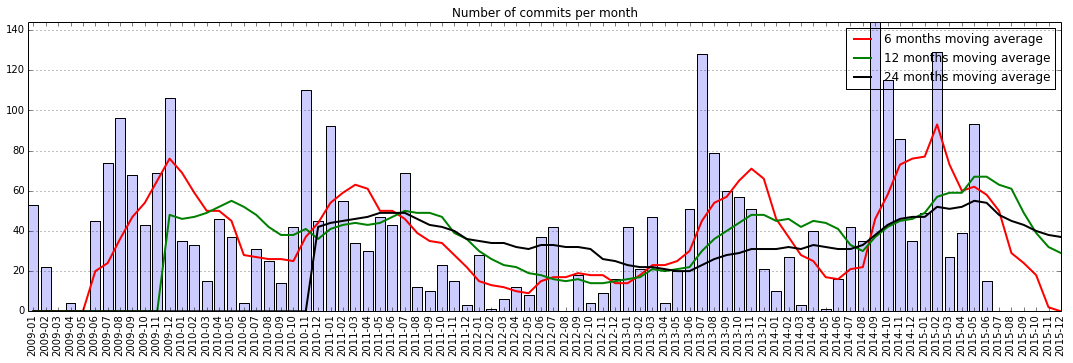

In [19]:
plot_frequencies_per_month(commits_per_month)
plt.title("Number of commits per month")
plt.show()

There is a peak of commits around 2014-09.

To see how data correlates it would be better to have the time period be releases instead of months. That way we can more easily see how the frequencies of emails and commits varies between releases of Timeline. Maybe the next analysis article?